In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 
from nerfstudio.utils.eval_utils import eval_setup
from inerf.inerf_trainer import load_data_into_trainer
from inerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose, get_image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_training_data_1/plane-nerf/2024-01-26_115109"
DATA_PATH = "/stored_data/test_dataset"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
TRANSFORM_FILE = "transforms_trans.json"
with open(GROUND_TRUTH_PATH) as f:
    GROUND_TRUTH = json.load(f)
with open(os.path.join(DATA_PATH, TRANSFORM_FILE)) as f:
    TRANSFORM = json.load(f)

In [4]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,TRANSFORM)


trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = False
)

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_training_data_1/plane-nerf/2024-01-26_115109/nerfstudio_models/step-000009999.ckpt

/workspace/inerf/inerf/inerf_utils.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  camera_to_worlds = torch.cat([camera_to_worlds, tensor([tf]).float()], 0)


Setting up training dataset...

Caching all 1 images.

Output()

[18:33:00] Saving checkpoints to:                                                                         ]8;id=628604;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=387049;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#134\134]8;;\
           outputs/jackal_training_data_1/plane-nerf/2024-01-26_115109/nerfstudio_models                                

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_training_data_1/plane-nerf/2024-01-26_115109/nerfstudio_models/step-000009999.ckpt

In [5]:
image, mask = trainer.pipeline.datamanager.setup_rays_inerf()

Number of keypoints:  66
Number of rays:  2969
Randomly select more rays
Final number of rays:  4096


In [6]:
trainer.pipeline.datamanager.get_inerf_raybundle_and_batch()

Number of keypoints:  66
Number of rays:  2969
Randomly select more rays
Final number of rays:  4096
{'image': tensor([[0.3608, 0.3608, 0.2392, 1.0000],
        [0.3647, 0.3647, 0.2431, 1.0000],
        [0.2745, 0.2745, 0.2745, 1.0000],
        ...,
        [0.3843, 0.3843, 0.2549, 1.0000],
        [0.3843, 0.3843, 0.2549, 1.0000],
        [0.3137, 0.3137, 0.2627, 1.0000]], dtype=torch.float64), 'mask': tensor([[True],
        [True],
        [True],
        ...,
        [True],
        [True],
        [True]]), 'indices': tensor([[  0, 256, 250],
        [  0, 256, 274],
        [  0, 256, 353],
        ...,
        [  0, 463, 427],
        [  0, 463, 430],
        [  0, 463, 454]])}


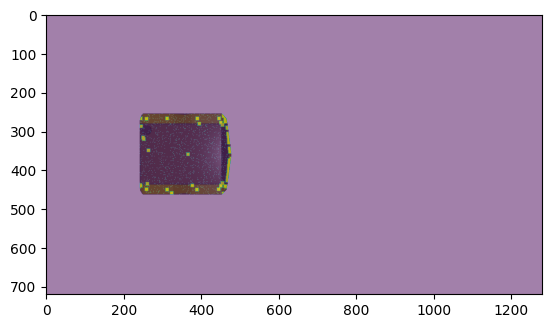

In [7]:
#Plot mask over image
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.show()

In [9]:
ray_bundle = trainer.pipeline.datamanager.inerf_ray_bundle
batch = trainer.pipeline.datamanager.inerf_batch
print(batch)

#Create blank 2D array
image = np.zeros((720, 1280, 3), dtype=np.float32)
cnt = np.zeros((720, 1280, 1), dtype=np.float32)

for i in range(len(batch['image'])):
    x,y = batch['indices'][i,1:]
    cnt[x,y] += 1
    image[x,y] = batch['image'][i,:3]

{'image': tensor([[0.3608, 0.3608, 0.2392, 1.0000],
        [0.3647, 0.3647, 0.2431, 1.0000],
        [0.2745, 0.2745, 0.2745, 1.0000],
        ...,
        [0.3843, 0.3843, 0.2549, 1.0000],
        [0.3843, 0.3843, 0.2549, 1.0000],
        [0.3137, 0.3137, 0.2627, 1.0000]], dtype=torch.float64), 'mask': tensor([[True],
        [True],
        [True],
        ...,
        [True],
        [True],
        [True]]), 'indices': tensor([[  0, 256, 250],
        [  0, 256, 274],
        [  0, 256, 353],
        ...,
        [  0, 463, 427],
        [  0, 463, 430],
        [  0, 463, 454]])}


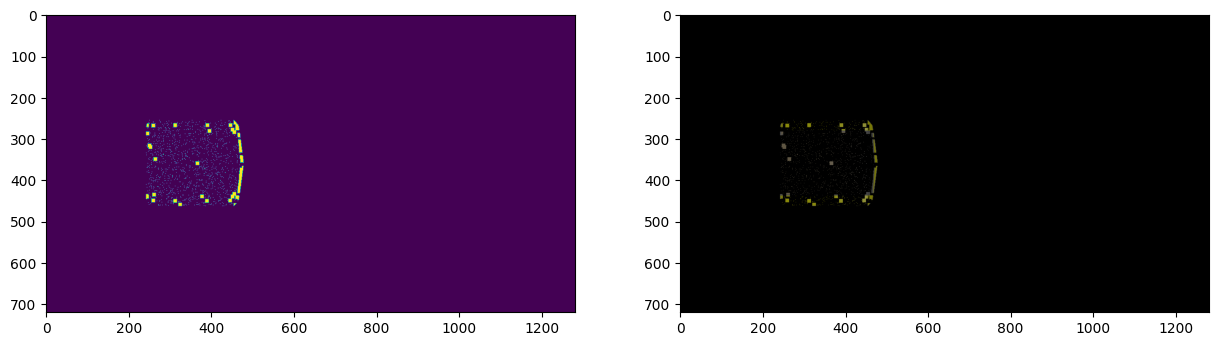

In [10]:
# Plot cnt and image in subplot
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(cnt)
ax[1].imshow(image)
plt.show()